In [ ]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import tensorflow as tf 
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, roc_auc_score
#from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.keras.callbacks import EarlyStopping

In [14]:
# Defining function to load the images
def load_data(data1, img_size=(128, 128)):
    images = []
    labels = []
    classes = ['COVID-19', 'Non-COVID', 'Normal']

    for class_name in classes:
        class_dir = os.path.join(data1, class_name, 'images')
        
        if not os.path.isdir(class_dir):
            print(f"Image directory {class_dir} does not exist.")
            continue
        
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            if os.path.isfile(img_path):
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is not None:
                    image = cv2.resize(image, img_size)
                    images.append(image)
                    labels.append(class_name)
                else:
                    print(f"Failed to read image {img_name} in {class_name}")
    
    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)
    return images, np.array(labels)
data1 = "C:/Users/chenn/Downloads/CovidXRayImages/Val"
#data1 = "C:/Users/saina/OneDrive/Desktop/Deep Learning/Val"
images, labels = load_data(data1)

In [16]:
# Normalize images
#normalizing the pixel values of the images 
#in raw form with pixel values with image range from 0 to 255.
images = images / 255.0

In [17]:
#  Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [18]:
#converting the labels to onehot encoding
# Initialize the LabelBinarizer
lb = LabelBinarizer()
# Fitting the LabelBinarizer to the training labels
y_train = lb.fit_transform(y_train)
#convert the test labels to one-hot encoding.
y_test = lb.transform(y_test)

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

In [7]:
#Deep Neural Network (DNN)
# Define DNN model with sequential container
dnn = Sequential([
    Flatten(input_shape=(128, 128, 1)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
# Compile the DNN model with Adam optimizer, categorical crossentropy loss, and accuracy metric
dnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Train the model
dnn.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
136/136 [==============================] - 17s 104ms/step - loss: 1.3282 - accuracy: 0.4890 - val_loss: 1.3215 - val_accuracy: 0.4945
Epoch 2/20
136/136 [==============================] - 13s 97ms/step - loss: 1.0734 - accuracy: 0.5541 - val_loss: 0.7519 - val_accuracy: 0.6716
Epoch 3/20
136/136 [==============================] - 14s 103ms/step - loss: 0.9483 - accuracy: 0.5853 - val_loss: 0.7621 - val_accuracy: 0.6780
Epoch 4/20
136/136 [==============================] - 14s 102ms/step - loss: 0.8795 - accuracy: 0.6144 - val_loss: 0.7985 - val_accuracy: 0.6707
Epoch 5/20
136/136 [==============================] - 14s 99ms/step - loss: 0.8277 - accuracy: 0.6289 - val_loss: 0.7399 - val_accuracy: 0.6827
Epoch 6/20
136/136 [==============================] - 14s 102ms/step - loss: 0.8052 - accuracy: 0.6517 - val_loss: 0.7426 - val_accuracy: 0.6910
Epoch 7/20
136/136 [==============================] - 14s 100ms/step - loss: 0.8019 - accuracy: 0.6501 - val_loss: 0.7287 - val_accu

In [8]:
# Generate probabilities for each class on the test data
dnnprob = dnn.predict(X_test)

34/34 [==============================] - 1s 22ms/step


In [9]:
# Convert probabilities to class predictions
dnnpred = np.argmax(dnnprob, axis=-1)

In [10]:
#compute the confusion matrix
#dnn_predictions are the expected class labels of the DNN model
dnn_confmatrix = confusion_matrix(np.argmax(y_test, axis=-1), dnnpred)

In [11]:

class_names = ['COVID-19', 'Non-COVID', 'Normal']

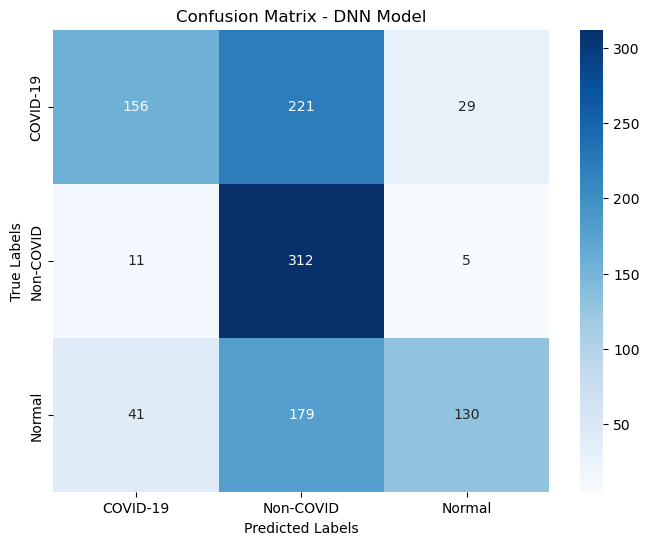

In [12]:
# Plotting the confusion matrix for the DNN model
plt.figure(figsize=(8, 6))
sns.heatmap(dnn_confmatrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - DNN Model')
plt.show()

In [13]:
dnn.save('coviddnn_model.keras')

In [14]:
#CNN Model
cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])
# Compile the CNN model with Adam optimizer, categorical crossentropy loss, and accuracy metric
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Training the model
cnn.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
136/136 [==============================] - 90s 636ms/step - loss: 1.1114 - accuracy: 0.3446 - val_loss: 1.0913 - val_accuracy: 0.4668
Epoch 2/20
136/136 [==============================] - 83s 610ms/step - loss: 1.0366 - accuracy: 0.4660 - val_loss: 0.9409 - val_accuracy: 0.5747
Epoch 3/20
136/136 [==============================] - 72s 530ms/step - loss: 0.9622 - accuracy: 0.5562 - val_loss: 0.8586 - val_accuracy: 0.6190
Epoch 4/20
136/136 [==============================] - 61s 449ms/step - loss: 0.9183 - accuracy: 0.5781 - val_loss: 0.8599 - val_accuracy: 0.6734
Epoch 5/20
136/136 [==============================] - 63s 463ms/step - loss: 0.9106 - accuracy: 0.5800 - val_loss: 0.8607 - val_accuracy: 0.6430
Epoch 6/20
136/136 [==============================] - 64s 474ms/step - loss: 0.8590 - accuracy: 0.6144 - val_loss: 0.8621 - val_accuracy: 0.6135
Epoch 7/20
136/136 [==============================] - 63s 461ms/step - loss: 0.8340 - accuracy: 0.6372 - val_loss: 0.7632 - val_ac

In [15]:
# Generate probabilities for each class on the test data
cnnprobab = cnn.predict(X_test)

34/34 [==============================] - 3s 91ms/step


In [16]:
cnnpred = np.argmax(cnnprobab, axis=-1)

In [17]:
cnn_confmatrix = confusion_matrix(np.argmax(y_test, axis=-1), cnnpred)

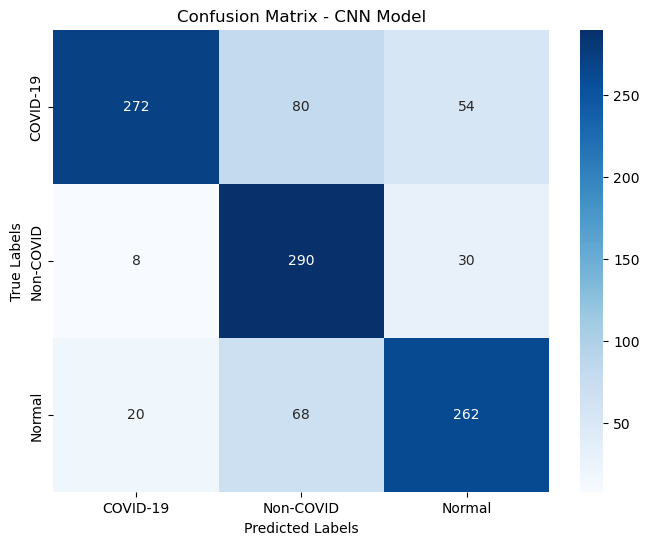

In [18]:
# Plotting the confusion matrix for the CNN model
plt.figure(figsize=(8, 6))
sns.heatmap(cnn_confmatrix, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - CNN Model')
plt.show()

In [19]:
cnn.save('covidcnn_model.keras')